# Analitica Predictiva


En el mundo del análisis de datos y el modelado predictivo, una parte fundamental es comprender en detalle la naturaleza y el comportamiento de los datos con los que estamos trabajando ya que serán el insumo del entrenamiento del modelo. Esto se logra mediante un Análisis Exploratorio de Datos (EDA, por sus siglas en inglés), que nos permite examinar las características de nuestros datos, tanto numéricas como categóricas, y comprender su distribución, tendencias y posibles relaciones entre variables. Esta exploración inicial es crucial para tomar decisiones informadas sobre cómo proceder con el modelado y la predicción.

Además de la exploración de los datos, también nos proponemos seleccionar los modelos de clasificación más adecuados para nuestro conjunto de datos. Para lograr esto, evaluaremos el rendimiento de tres modelos ampliamente utilizados en la clasificación: Support Vector Machines (SVM), Random Forest Classifier y Gradient Boosting Trees. Estos modelos ofrecen enfoques diferentes para la clasificación y pueden adaptarse a una variedad de situaciones y tipos de datos.

El proceso de selección de modelos implica entrenar y evaluar cada modelo utilizando métricas específicas, como la precisión (accuracy) y el recall. Además, exploraremos diferentes combinaciones de hiperparámetros para cada modelo, con el objetivo de encontrar la configuración óptima que maximice el rendimiento predictivo.

En resumen, este informe tiene como objetivo realizar un análisis exhaustivo de nuestros datos mediante un EDA detallado, seguido de la selección y evaluación de modelos de clasificación para predecir con precisión las etiquetas de clasificación, y posteriormente su probabilidad. Al finalizar, esperamos haber obtenido una comprensión profunda de nuestros datos y haber identificado el modelo o modelos que mejor se ajusten a nuestras necesidades de predicción.

## Importación de librerias

In [40]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC  
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV,cross_val_score,ShuffleSplit
from sklearn import tree
import psycopg2
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,recall_score,precision_score,f1_score
from sklearn.linear_model import LogisticRegression
import shap


## Importación de datos

Nos conectamos a la Base de datos que tenemos en la nube

In [3]:
conn = psycopg2.connect(
    dbname="neondb",
    user="neondb_owner",
    password="YexCUXob4Oy7",
    host="ep-little-feather-a5rorog4.us-east-2.aws.neon.tech",
    port="5432"
)
cursor = conn.cursor()

cursor.execute("SELECT * FROM companies")

# Obtener los datos y guardarlos en un DataFrame
data2 = cursor.fetchall()
df = pd.DataFrame(data2)

In [4]:
df.columns=['company', 'sector', 'horizon_days', 'amount', 'date_BUY_fix',
       'date_SELL_fix', 'price_BUY', 'price_SELL', 'Volatility_Buy',
       'Volatility_sell', 'Sharpe_Ratio', 'expected_return_yearly',
       'inflation', 'nominal_return', 'investment', 'ESG_ranking', 'PE_ratio',
       'EPS_ratio', 'PS_ratio', 'PB_ratio', 'NetProfitMargin_ratio',
       'current_ratio', 'roa_ratio', 'roe_ratio']

In [5]:
mapeo = {'GOOD': 1, 'BAD': 0}

# Aplicar el mapeo a la columna 'categoria'
df['investment'] = df['investment'].map(mapeo)

El siguiente es el dataframe con el vamos a trabajar

In [6]:
df.head()

,company,sector,horizon_days,amount,date_BUY_fix,date_SELL_fix,price_BUY,price_SELL,Volatility_Buy,Volatility_sell,...,investment,ESG_ranking,PE_ratio,EPS_ratio,PS_ratio,PB_ratio,NetProfitMargin_ratio,current_ratio,roa_ratio,roe_ratio
0,HMC,AUTO,7,500.0,2016-06-14,2016-06-21,25.600000,26.410000,0.274761,0.274900,...,1,28.5,13.50,1.64,0.32,0.00,2.40,1.11,1.93,4.87
1,MSFT,TECH,330,1500.0,2016-07-22,2017-06-16,52.356224,66.406387,0.279043,0.160044,...,1,14.7,23.18,2.05,4.19,5.15,22.53,2.35,11.28,27.29
2,BAC,BANK,15,25000.0,2015-01-28,2015-02-12,13.609470,14.925651,0.228531,0.232711,...,1,26.3,42.16,0.38,1.77,0.69,4.62,0.94,0.21,1.88
3,KSS,RETAIL,270,50000.0,2015-01-28,2015-10-26,47.355690,36.093388,0.221473,0.292144,...,0,12.9,10.87,4.26,0.50,1.55,4.56,1.95,6.03,14.78
4,AAPL,TECH,600,10000.0,2015-05-21,2017-01-10,30.166021,28.201811,0.217025,0.227415,...,0,16.5,14.06,2.02,3.19,5.08,22.53,1.16,19.56,39.44


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   company                 900 non-null    object 
 1   sector                  900 non-null    object 
 2   horizon_days            900 non-null    int64  
 3   amount                  900 non-null    float64
 4   date_BUY_fix            900 non-null    object 
 5   date_SELL_fix           900 non-null    object 
 6   price_BUY               900 non-null    float64
 7   price_SELL              900 non-null    float64
 8   Volatility_Buy          900 non-null    float64
 9   Volatility_sell         900 non-null    float64
 10  Sharpe_Ratio            900 non-null    float64
 11  expected_return_yearly  900 non-null    float64
 12  inflation               900 non-null    float64
 13  nominal_return          900 non-null    float64
 14  investment              900 non-null    in

## Parametrización

Como buenas practicas, empezamos a parametrizar nuestro desarrollo sacando las columnas objetivo, variables a eliminar, variables numericas y categroicas, etc

In [8]:
independent_var_erase=['sector','company','date_BUY_fix','date_SELL_fix', 'amount', 'Volatility_sell','Volatility_Buy']
dependent_var='investment'
independent_var=[x for x in df.columns if x not in independent_var_erase and x not in dependent_var]

In [9]:
X=df[independent_var]
y=df[dependent_var]

# Seleccionar columnas categoricas
VAR_categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Seleccionar columnas numericas
VAR_numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

# Total de columnas
VAR_cols = VAR_categorical_cols + VAR_numerical_cols

print('Variables categoricas: ',VAR_categorical_cols)
print('Variables numericas: ',VAR_numerical_cols)
print('Variables independientes: ',VAR_cols)

Variables categoricas:  []
Variables numericas:  ['horizon_days', 'price_BUY', 'price_SELL', 'Sharpe_Ratio', 'expected_return_yearly', 'inflation', 'nominal_return', 'ESG_ranking', 'PE_ratio', 'EPS_ratio', 'PS_ratio', 'PB_ratio', 'NetProfitMargin_ratio', 'current_ratio', 'roa_ratio', 'roe_ratio']
Variables independientes:  ['horizon_days', 'price_BUY', 'price_SELL', 'Sharpe_Ratio', 'expected_return_yearly', 'inflation', 'nominal_return', 'ESG_ranking', 'PE_ratio', 'EPS_ratio', 'PS_ratio', 'PB_ratio', 'NetProfitMargin_ratio', 'current_ratio', 'roa_ratio', 'roe_ratio']


## Modelos de clasificación

En la ciencia de datos y el aprendizaje automático, la selección de un modelo apropiado es crucial para el éxito de cualquier tarea de predicción. Aquí, proporcionamos una descripción detallada de tres técnicas avanzadas de clasificación: Máquinas de Vectores de Soporte (SVM), Clasificador de Bosques Aleatorios (Random Forest) y Clasificadores de Impulso Gradiente (Gradient Boosting). Estos métodos se emplean ampliamente debido a su robustez, eficacia y precisión en una variedad de tareas predictivas.

1. Máquinas de Vectores de Soporte (Support Vector Machines, SVM)

Las Máquinas de Vectores de Soporte (SVM) son modelos de aprendizaje supervisado que analizan datos y reconocen patrones, utilizados principalmente en problemas de clasificación y regresión. En términos de clasificación, el objetivo principal de una SVM es encontrar el hiperplano que mejor divide un conjunto de instancias en varias clases de manera que quede un máximo margen entre los puntos de las diferentes clases.

Características Principales:

Maximización del Margen: SVM busca el hiperplano que maximiza el margen entre las clases. Este margen es calculado como la distancia entre las líneas más cercanas al hiperplano que no tienen puntos entre ellas.

Vectores de Soporte: Los puntos más cercanos al hiperplano que definen el margen se conocen como vectores de soporte. Estos son los datos que ayudan a construir el hiperplano.

Kernels: Para datos que no son linealmente separables en su espacio original, SVM utiliza funciones de kernel para transformar el espacio de entrada en un nuevo espacio donde es posible realizar la separación lineal.

2. Clasificador de Bosques Aleatorios (Random Forest Classifier)

El Clasificador de Bosques Aleatorios es un método de ensemble que opera construyendo una multitud de árboles de decisión durante el entrenamiento y outputting la clase que es la moda de las clases clasificadas por árboles individuales.

Características Principales:
Ensemble Learning: Random Forest combina múltiples árboles de decisión para aumentar la precisión de la clasificación.

Reducción de Overfitting: A diferencia de los árboles de decisión individuales, Random Forest previene el overfitting al promediar o "ensemble" los resultados de varios árboles.

Importancia de las Características: Este modelo proporciona una buena indicación de la importancia de las características en la clasificación.

3. Clasificadores de Impulso Gradiente (Gradient Boosting Classifiers)

Los Clasificadores de Impulso Gradiente son otra técnica de ensemble que construye el modelo de manera secuencial cada uno intentando corregir los errores del modelo anterior. Está entre los métodos más poderosos y ampliamente utilizados para tareas competitivas de clasificación.

Características Principales:

Boosting: Esta técnica combina múltiples modelos débiles de manera secuencial para crear un modelo robusto.

Minimización de la Pérdida: En cada iteración, se añade un nuevo modelo que minimiza la función de pérdida global, lo cual mejora la precisión del modelo global.

Flexibilidad: Puede utilizar diferentes funciones de pérdida y es efectivo en varias distribuciones de datos, incluyendo errores y outliers.


Estos modelos representan herramientas sofisticadas y potentes para cualquier científico de datos que busque realizar análisis predictivos de alta precisión en problemas complejos de clasificación. Cada uno tiene sus fortalezas y contextos de aplicación ideales, por lo que la elección debe basarse en las necesidades específicas del problema y la naturaleza de los datos disponibles.

## Metodologia propuesta

Ahora, la idea es hacer una tuberia de datos tal que cuando lleguen los datos nuevos a estimar, estos pasen por las mismas transformaciones por las que pasaron los datos de entrenamiento. Más precisamente hablando, el pipeline en scikit-learn es una herramienta que te permite concatenar varios pasos de procesamiento de datos y modelado en un solo objeto. Esto facilita la construcción, entrenamiento y evaluación de modelos de aprendizaje automático, ya que puedes encapsular todo el flujo de trabajo en una única estructura.

````{figure} ./figures/Resource-Pipeline-CU-Predictor-Favorabilidad-Compra-Acciones.png
:name: Resource-Pipeline-CU-Predictor-Favorabilidad-Compra-Acciones_fig
:align: center

Funcionamiento de pipelines en SciKit-learn
````

De la misma manera, se busca optimizar las estimaciones y la calidad de los modelos, por lo que se usa la metodologia de Grid search o busqueda de malla para optimizar parametros dentro de los modelos. Es una herramienta poderosa para optimizar los hiperparámetros de un modelo de aprendizaje automático. Permite definir una cuadrícula de valores para diferentes hiperparámetros del modelo y busca exhaustivamente la mejor combinación de estos hiperparámetros.

En términos más simples, el GridSearchCV realiza una búsqueda exhaustiva sobre una cuadrícula de valores especificados para los hiperparámetros de un estimador. Esto permite encontrar la combinación óptima de hiperparámetros que maximiza la precisión o cualquier otra métrica de evaluación definida.

La idea detrás del GridSearchCV es que, en lugar de ajustar manualmente los hiperparámetros del modelo y evaluar su rendimiento, el proceso se automatiza y se realiza de manera sistemática. Esto ahorra tiempo y esfuerzo, ya que el GridSearchCV evalúa todas las combinaciones posibles de los hiperparámetros dentro de la cuadrícula especificada y selecciona la mejor combinación según la métrica de evaluación especificada.

````{figure} ./figures/Grid_serach.png
:name: Grid_search_fig
:align: center

Funcionamiento de la busqueda de malla (Grid Search) en SciKit-learn
````

## Support Vector Machines

Como se menciona anteriormente, Se propone hiper-parametrizar cada modelo junto con la aplciacion de pipelines de preprocesamiento, ahora, se busca que en los modelos propuestos se entrenen mediante validación cruzada anidada. En esta técnica, se busca tener un bucle externo sobre las divisiones de los datos en conjuntos de entrenamiento y de prueba. Para cada uno de ellos, se ejecuta una búsqueda en red, lo cual puede dar lugar a diferentes parámetros óptimos para cada división en el bucle externo

In [10]:
preprocessor_svc = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), VAR_numerical_cols)
    ],
    remainder='passthrough'
)

In [11]:
param_grid_svc={'classifier__C': [0.1,1, 10,100], 'classifier__kernel': ['linear', 'rbf','sigmoid'],'classifier__gamma':[0.1,1, 10,100]}

In [12]:
pipelines_svc = Pipeline([
        ('preprocessor', preprocessor_svc),
        ('classifier', SVC())
])

La funcion ShuffleSplit divide los datos en conjuntos de entrenamiento y prueba de tamaño igual (50% cada uno en este caso) de forma aleatoria en cada iteración de la validación cruzada. Esto ayuda a obtener una estimación más robusta del rendimiento del modelo al promediar los resultados sobre múltiples divisiones aleatorias de los datos.

test_size: Esto especifica el tamaño del conjunto de datos de prueba. En este caso, se establece en 0.5, lo que significa que el 50% de los datos se utilizarán como conjunto de prueba en cada iteración de la validación cruzada.

train_size: Esto especifica el tamaño del conjunto de datos de entrenamiento. Al igual que test_size, está establecido en 0.5, lo que significa que el 50% de los datos se utilizarán como conjunto de entrenamiento en cada iteración de la validación cruzada.

n_splits: Esto especifica el número de divisiones diferentes que se crearán en los datos. En este caso, se establece en 10, lo que significa que se realizarán 10 iteraciones de la validación cruzada.

In [13]:
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)

In [14]:
grid_search_svc = GridSearchCV(pipelines_svc, param_grid_svc, cv=shuffle_split, scoring='recall')
grid_search_results = cross_val_score(grid_search_svc, X, y, cv=5)


print("Cross-validation scores: ", grid_search_results)
print("Mean cross-validation score: ", grid_search_results.mean())

Cross-validation scores:  [0.97101449 0.95652174 0.95652174 0.98550725 0.95588235]
Mean cross-validation score:  0.9650895140664962


In [15]:
ajuste_svc=grid_search_svc.fit(X, y)
best_model_svc=ajuste_svc.best_estimator_

# Resultados de la búsqueda de hiperparámetros
print("Mejores parámetros encontrados:", best_model_svc['classifier'])

Mejores parámetros encontrados: SVC(C=0.1, gamma=0.1, kernel='linear')


In [16]:
best_model_svc

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['horizon_days', 'price_BUY',
                                                   'price_SELL', 'Sharpe_Ratio',
                                                   'expected_return_yearly',
                                                   'inflation',
                                                   'nominal_return',
                                                   'ESG_ranking', 'PE_ratio',
                                                   'EPS_ratio', 'PS_ratio',
                                                   'PB_ratio',
                                                   'NetProfitMargin_ratio',
                                                   'current_ratio', 'roa_ratio',
                                                   'roe_ratio'])])),
                ('classifier', SVC(C=0.1, gamma=0.1, kernel='linear'))])

## Random Forest

In [17]:
param_grid_rf={'n_estimators': [50, 100,200], 'max_depth': [None, 10,20],'min_samples_split': [2, 5, 10]}

In [18]:
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=shuffle_split, scoring='recall')
grid_search_results_rf = cross_val_score(grid_search_rf, X, y, cv=5)


print("Cross-validation scores: ", grid_search_results_rf)
print("Mean cross-validation score: ", grid_search_results_rf.mean())

Cross-validation scores:  [1.         0.98550725 0.98550725 1.         1.        ]
Mean cross-validation score:  0.9942028985507246


In [19]:
ajuste_rf=grid_search_rf.fit(X, y)
best_model_rf=ajuste_rf.best_estimator_

# Resultados de la búsqueda de hiperparámetros
print("Mejores parámetros encontrados:", best_model_rf)

Mejores parámetros encontrados: RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=50)


In [20]:
best_model_rf

RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=50)

## XGBoost

In [21]:
param_grid_xgb={'n_estimators': [50, 100,200], 'learning_rate': [0.01, 0.1,1],'max_depth': [None, 10,20],'subsample':[0.5,0.8,1]}

In [22]:
grid_search_xgb = GridSearchCV(GradientBoostingClassifier(), param_grid_xgb, cv=shuffle_split, scoring='recall')
grid_search_results_xgb = cross_val_score(grid_search_xgb, X, y, cv=5)


print("Cross-validation scores: ", grid_search_results_xgb)
print("Mean cross-validation score: ", grid_search_results_xgb.mean())

Cross-validation scores:  [1.         1.         0.98550725 1.         1.        ]
Mean cross-validation score:  0.9971014492753623


In [23]:
ajuste_xgb=grid_search_xgb.fit(X, y)
best_model_xgb=ajuste_xgb.best_estimator_

# Resultados de la búsqueda de hiperparámetros
print("Mejores parámetros encontrados:", best_model_xgb)

Mejores parámetros encontrados: GradientBoostingClassifier(learning_rate=0.01, max_depth=None, n_estimators=50,
                           subsample=0.8)


## Regresión Logistica

In [38]:
preprocessor_log = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), VAR_numerical_cols)
    ],
    remainder='passthrough'
)

In [39]:
param_grid_rl = {
    'classifier__C': [0.0001,0.001,0.1, 1, 10, 100], 
    'classifier__penalty': ['l1', 'l2'],  
    'classifier__solver': ['liblinear', 'lbfgs', 'saga']  
}


In [41]:
pipelines_rl = Pipeline([
        ('preprocessor', preprocessor_log),
        ('classifier', LogisticRegression())
])

In [46]:
# Apagamos las warnings porque el optimizador interno de LogisticRegression() no converge en un minimo local

import warnings

# Desactiva las advertencias
warnings.filterwarnings("ignore")

grid_search_log = GridSearchCV(pipelines_rl, param_grid_rl, cv=shuffle_split, scoring='recall')
grid_search_results_log = cross_val_score(grid_search_log, X, y, cv=5)


print("Cross-validation scores: ", grid_search_results_log)
print("Mean cross-validation score: ", grid_search_results_log.mean())


# Vuelve a activar las advertencias
warnings.filterwarnings("default")

Cross-validation scores:  [0.98550725 0.98550725 0.97101449 1.         1.        ]
Mean cross-validation score:  0.9884057971014493


In [48]:
import warnings

# Desactiva las advertencias
warnings.filterwarnings("ignore")

ajuste_log=grid_search_log.fit(X, y)
best_model_log=ajuste_log.best_estimator_

# Resultados de la búsqueda de hiperparámetros
print("Mejores parámetros encontrados:", best_model_log['classifier'])

# Vuelve a activar las advertencias
warnings.filterwarnings("default")

Mejores parámetros encontrados: LogisticRegression(C=0.1, penalty='l1', solver='liblinear')


## Medición de métricas

Por último, vemos los 3 objetos entrenados:

In [49]:
print(best_model_svc)
print(best_model_rf)
print(best_model_xgb)
print(best_model_log)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['horizon_days', 'price_BUY',
                                                   'price_SELL', 'Sharpe_Ratio',
                                                   'expected_return_yearly',
                                                   'inflation',
                                                   'nominal_return',
                                                   'ESG_ranking', 'PE_ratio',
                                                   'EPS_ratio', 'PS_ratio',
                                                   'PB_ratio',
                                                   'NetProfitMargin_ratio',
                                                   'current_ratio', 'roa_ratio',
                                                   'roe_ratio'])])),
                ('

Miramos el reporte de métricas completas que nos ofrece Sklearn

Usamos un conjunto de datos de validación que proviene de fuentes locales, para simular con datos nuevos empresariales que vienen de afuera y que aún no conoce el modelo

In [25]:
# carga de datos local
ruta2='C:/Users/Pc Com/Documents'
data2 = os.path.join(ruta2, 'final_transactions_dataset.csv')
data2 = pd.read_csv(data2)
data2=data2.drop('id', axis=1)
mapeo2 = {'GOOD': 1, 'BAD': 0}

# Aplicar el mapeo a la columna 'categoria'
data2['investment'] = data2['investment'].map(mapeo2)
data2=data2.rename(columns={'horizon (days)':'horizon_days','Sharpe Ratio':'Sharpe_Ratio','expected_return (yearly)':'expected_return_yearly'})
data2=data2.sample(n=450,replace=False).reset_index(drop=True)

In [26]:
X_valid=data2[independent_var]
y_valid=data2[dependent_var]

In [50]:
# Calcular las métricas para el SVC
y_pred1 = best_model_svc.predict(X_valid)
precision1 = precision_score(y_valid, y_pred1)
recall1 = recall_score(y_valid, y_pred1)
accuracy1 = accuracy_score(y_valid, y_pred1)
f1_score1 = f1_score(y_valid, y_pred1)

# Calcular las métricas para el RandomForest
y_pred2 = best_model_rf.predict(X_valid)
precision2 = precision_score(y_valid, y_pred2)
recall2 = recall_score(y_valid, y_pred2)
accuracy2 = accuracy_score(y_valid, y_pred2)
f1_score2 = f1_score(y_valid, y_pred2)

# Calcular las métricas para el XGBoost
y_pred3 = best_model_xgb.predict(X_valid)
precision3 = precision_score(y_valid, y_pred3)
recall3 = recall_score(y_valid, y_pred3)
accuracy3 = accuracy_score(y_valid, y_pred3)
f1_score3 = f1_score(y_valid, y_pred3)

# Calcular las métricas para el logistico
y_pred4 = best_model_log.predict(X_valid)
precision4 = precision_score(y_valid, y_pred4)
recall4 = recall_score(y_valid, y_pred4)
accuracy4 = accuracy_score(y_valid, y_pred4)
f1_score4 = f1_score(y_valid, y_pred4)

In [51]:
data_reporte = {
    'Modelo': ['Support Vector Classifier', 'Random Forest Classifier', 'XGBoost Classifier','Logisic Regression'],
    'Precision': [precision1, precision2, precision3,precision4],
    'Recall': [recall1, recall2, recall3,recall4],
    'Accuracy': [accuracy1, accuracy2, accuracy3,accuracy4],
    'F1-score': [f1_score1, f1_score2, f1_score3,f1_score4]
}

df_reporte = pd.DataFrame(data_reporte)

Rendimiento de modelos para conjunto de datos de valdiación

In [52]:
df_reporte

,Modelo,Precision,Recall,Accuracy,F1-score
0,Support Vector Classifier,0.780488,0.958084,0.884444,0.860215
1,Random Forest Classifier,1.000000,0.994012,0.997778,0.996997
2,XGBoost Classifier,1.000000,1.000000,1.000000,1.000000
3,Logisic Regression,0.835052,0.970060,0.917778,0.897507


In [53]:
conf_matrix_svc = confusion_matrix(y_valid, y_pred1)
print("Matriz de Confusión SVC:\n", conf_matrix_svc)

conf_matrix_rf = confusion_matrix(y_valid, y_pred2)
print("Matriz de Confusión RandomForest:\n", conf_matrix_rf)

conf_matrix_xgb = confusion_matrix(y_valid, y_pred3)
print("Matriz de Confusión XGBoost:\n", conf_matrix_xgb)

conf_matrix_log = confusion_matrix(y_valid, y_pred4)
print("Matriz de Confusión XGBoost:\n", conf_matrix_log)

Matriz de Confusión SVC:
 [[238  45]
 [  7 160]]
Matriz de Confusión RandomForest:
 [[283   0]
 [  1 166]]
Matriz de Confusión XGBoost:
 [[283   0]
 [  0 167]]
Matriz de Confusión XGBoost:
 [[251  32]
 [  5 162]]


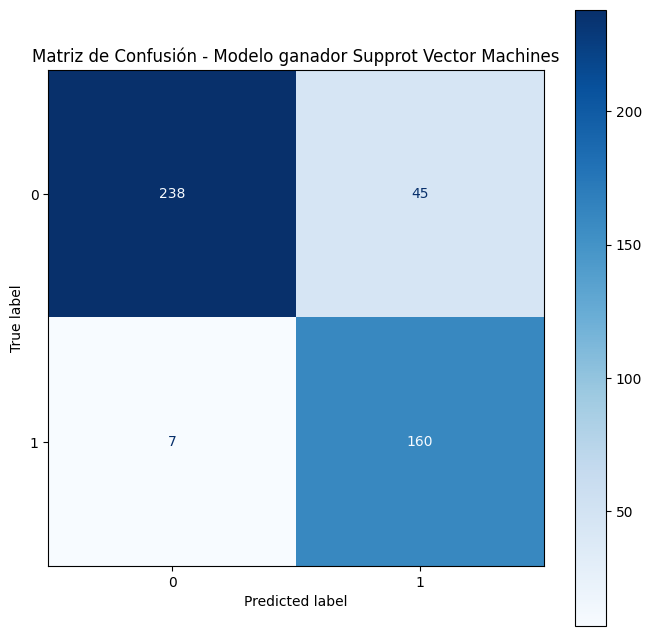

In [31]:
# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svc)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues')
plt.title("Matriz de Confusión - Modelo ganador Supprot Vector Machines")
plt.show()

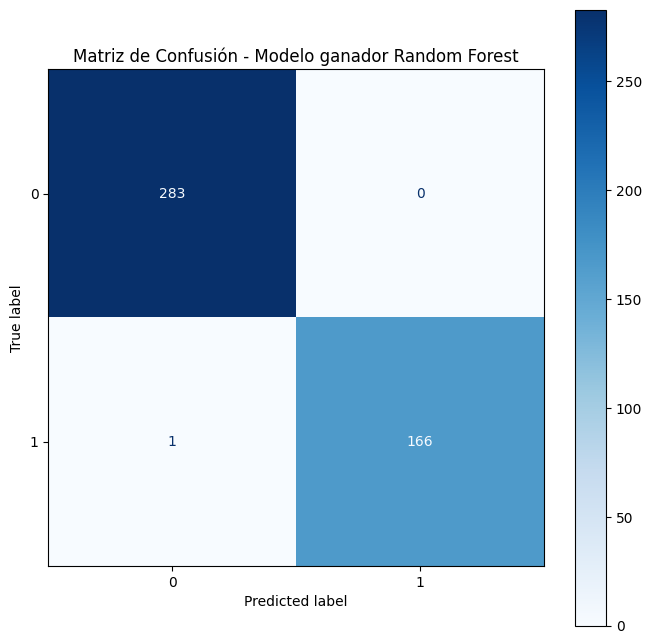

In [32]:
# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues')
plt.title("Matriz de Confusión - Modelo ganador Random Forest")
plt.show()

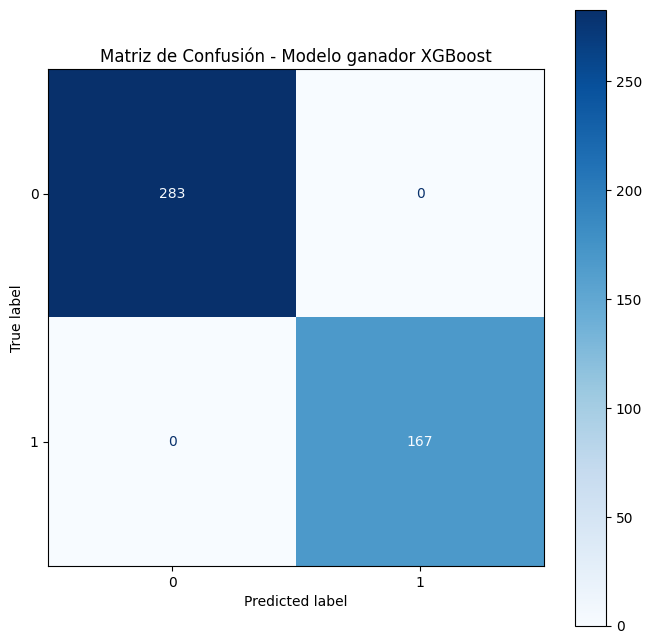

In [33]:
# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues')
plt.title("Matriz de Confusión - Modelo ganador XGBoost")
plt.show()

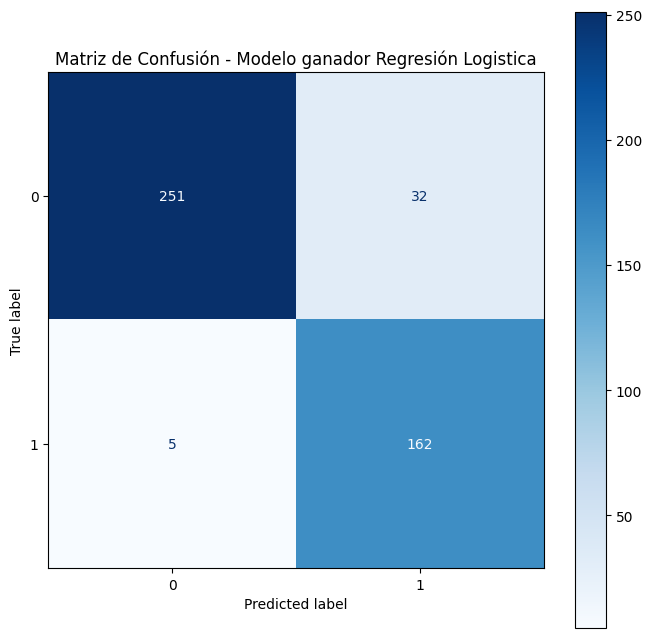

In [54]:
# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_log)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues')
plt.title("Matriz de Confusión - Modelo ganador Regresión Logistica")
plt.show()

Como podemos observar con los datos que nunca ha visto el modelo:

- El modelo de clasificación XGBoost posee un valor de recall de 1, tanto en conjuntos de datos de pruebas como en conjunto de validaciones. Esto se puede deber a que los datos de entrenamiento de este problema de clasificación sean intrínsecamente fácil para el modelo que estás utilizando, por lo que puede obtener un rendimiento perfecto en todos los conjuntos de datos.

- Respecto al Random Forest, vemos que el rendimiento del modelo en el conjunto de datos de prueba nos presenta valores de recall demasiado altos, los cuales en el conjunto de datos de valdiación, que son datos que nunca ha visto, se ven reflejados con los mismos comportamientos en su rendimiento. Este es el modelo 

- Respecto al modelo de support vector machines, tuvimos que usar preprocesamiento de escalamiento de datos para que todo esté aproximadamente en la misma escala. Este fue el modelo que posee más generalizacion de los demas, lo podemos ver reflejado en sus medidas de rendimientos.

## Visibilidad y entendimiento del modelo

En esta sección buscamos entender cómo es el modelo de RandomForest, mediante varias tecnicas

El "feature importance" (importancia de las características) en un modelo de aprendizaje automático, indica cuánto contribuye cada característica (o atributo) al rendimiento general del modelo en la tarea de predicción. Es una medida útil para entender qué características son más relevantes para la predicción de la variable objetivo.

En este caso podemos ver que la variable `inflation` y `nominal_return` (Inflación durante la variable horizon_days y Retorno nominal) aporta mas 35% en la prediccion de si la firma es buena para invertir o no, dando a entender que para **este** modelo en especifico son variables importantes

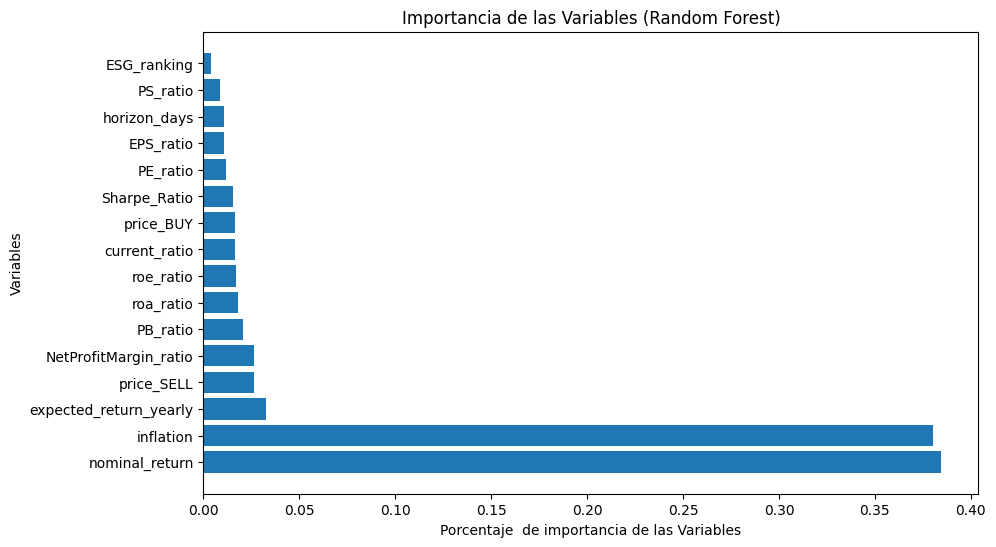

In [34]:
# Obtener la importancia de las características
feature_importances = best_model_rf.feature_importances_

# Obtener los nombres de las características
feature_names = X_valid.columns  # Reemplaza esto con el nombre de tus características si tienes

# Ordenar las características por su importancia
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importances)
plt.xlabel('Porcentaje  de importancia de las Variables')
plt.ylabel('Variables')
plt.title('Importancia de las Variables (Random Forest)')
plt.show()

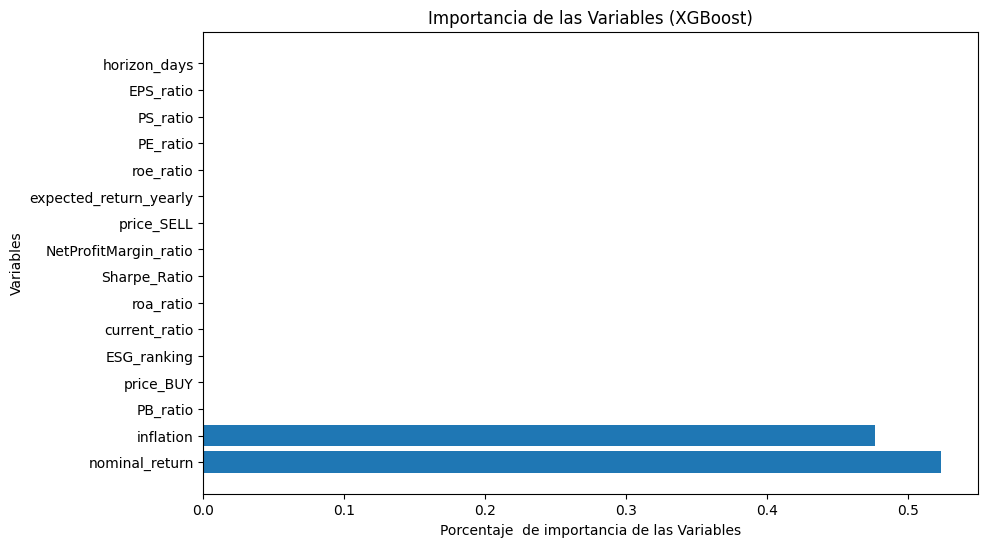

In [55]:
# Obtener la importancia de las características
feature_importances = best_model_xgb.feature_importances_

# Obtener los nombres de las características
feature_names = X_valid.columns  # Reemplaza esto con el nombre de tus características si tienes

# Ordenar las características por su importancia
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importances)
plt.xlabel('Porcentaje  de importancia de las Variables')
plt.ylabel('Variables')
plt.title('Importancia de las Variables (XGBoost)')
plt.show()

## Importación de modelos

In [35]:
# Guardar el modelo SVC en un archivo
clf_svm=best_model_svc
joblib.dump(clf_svm, 'C:/Users/Pc Com/Documents/modelo_ganador_svc.joblib')

['C:/Users/Pc Com/Documents/modelo_ganador_svc.joblib']

In [36]:
# Guardar el modelo RF en un archivo
clf_rf=best_model_rf
joblib.dump(clf_rf, 'C:/Users/Pc Com/Documents/modelo_ganador_rf.joblib')

['C:/Users/Pc Com/Documents/modelo_ganador_rf.joblib']

In [37]:
# Guardar el modelo XGB en un archivo
clf_xgb=best_model_xgb
joblib.dump(clf_xgb, 'C:/Users/Pc Com/Documents/modelo_ganador_xbg.joblib')

['C:/Users/Pc Com/Documents/modelo_ganador_xbg.joblib']

In [56]:
# Guardar el modelo XGB en un archivo
clf_log=best_model_log
joblib.dump(clf_log, 'C:/Users/Pc Com/Documents/modelo_ganador_log.joblib')

['C:/Users/Pc Com/Documents/modelo_ganador_log.joblib']